In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lmfit import Model
import datetime


In [57]:
# load data
file = 'D:/RAW_2023-12-11(20)/red_green_ratio.csv'
data = pd.read_csv(file, decimal=',')
print(data)


    Temperature/O2  Intensity Ratio  Intensity Red  Intensity Green  \
0              0.0         2.507614    2857.081062      1139.585074   
1             10.0         2.136164    2039.045674       954.535985   
2             20.0         1.941577    1716.399948       884.151520   
3             30.0         1.798339    1507.933883       838.613194   
4             40.0         1.685396    1356.903680       805.197320   
5             50.0         1.592114    1240.359775       779.141114   
6             60.0         1.527279    1164.537523       762.589157   
7             70.0         1.466905    1097.549892       748.308788   
8             80.0         1.417298    1041.026566       734.632671   
9             90.0         1.371225     992.910932       724.226089   
10            99.0         1.335637     957.255975       716.848003   
11             0.0         2.508586    2859.759058      1140.209351   
12            10.0         2.138670    2047.228769       957.283218   
13    

In [58]:
# Group the data by Air Saturation and calculate the mean ratio for each air saturation value
grouped_data = data.groupby('Temperature/O2').mean()#.round(4)
print(grouped_data)

# Get the R0 value: Intensity Ratio at Air Saturation = 0%
R0 = grouped_data.iloc[0, 0]
print('this is R0', R0)

# Normalize the data by R0/R
grouped_data['Intensity Ratio'] = R0 / grouped_data['Intensity Ratio']  
print(grouped_data)


                Intensity Ratio  Intensity Red  Intensity Green  \
Temperature/O2                                                    
0.0                    2.508261    2858.439512      1139.833772   
10.0                   2.137031    2041.396907       955.275719   
20.0                   1.939292    1713.648040       883.759215   
30.0                   1.797373    1507.436243       838.778703   
40.0                   1.684950    1357.161157       805.561824   
50.0                   1.594315    1243.711587       780.174788   
60.0                   1.528640    1167.179667       763.643156   
70.0                   1.467586    1098.739279       748.776680   
80.0                   1.417812    1043.147930       735.862237   
90.0                   1.371627     994.484973       725.161690   
99.0                   1.336144     959.214112       718.040965   

                Intensity Blue  Std Ratio    Std Red  Std Green   Std Blue  
Temperature/O2                                     

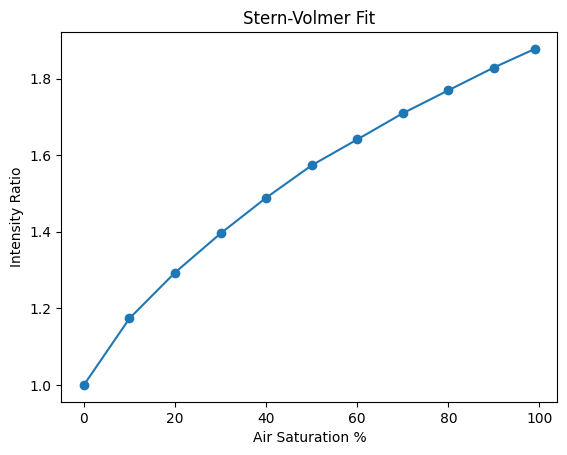

In [59]:
# Create a plot
plt.plot(grouped_data.index, grouped_data['Intensity Ratio'], 'o-')

# Set the x-axis and y-axis labels
plt.title('Stern-Volmer Fit')
plt.xlabel('Air Saturation %')
plt.ylabel('Intensity Ratio')
plt.show()

In [60]:
# define simplified Stern-Volmer function
def _sternvolmer_simple(x, f, k):
    """
    fitting function according to the common two site model. In general, x represents the pO2 or pCO2 content, whereas
    m, k and f are the common fitting parameters
    :param x:   list
    :param k:   np.float
    :param f:   np.float
    :return:
    """
    # R0/R
    int_ratio = 1 / (f / (1. + k*x) + (1.-f))
    return int_ratio
 

# make your function a model to be used by lmfit
simple_sv = Model(_sternvolmer_simple)

In [61]:
# set initial parameter
params_sens = simple_sv.make_params(k=0.165, f=0.887) # from previous calibrations approximately known
params_sens['k'].min = 0.
params_sens['f'].max = 1.

# use R0/R data for fit and re-calculate i afterwards
# full concentration range
ytofit_sens = grouped_data['Intensity Ratio'].to_numpy()
xtofit_sens = grouped_data.index.to_numpy() 
result = simple_sv.fit(ytofit_sens, params_sens, x=xtofit_sens, nan_policy='omit')

[[Model]]
    Model(_sternvolmer_simple)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 11
    # variables        = 1
    chi-square         = 6.6370e-04
    reduced chi-square = 6.6370e-05
    Akaike info crit   = -104.871313
    Bayesian info crit = -104.473417
    R-squared          = 0.99916644
[[Variables]]
    f:  0.64209914 +/- 0.00155903 (0.24%) (init = 0.6420991)
    k:  0.02643078 (fixed)


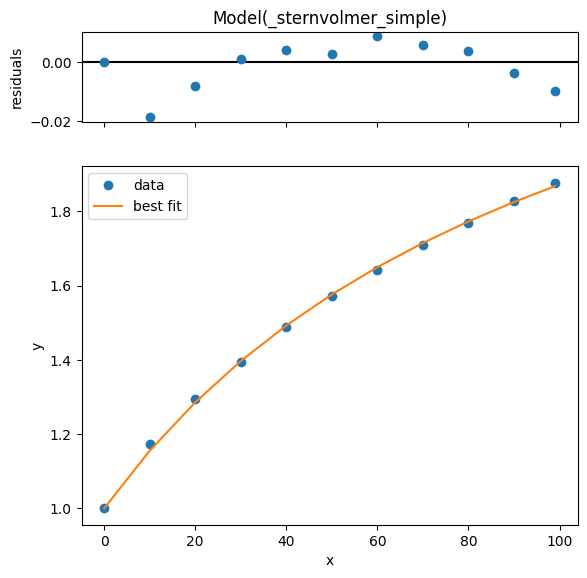

In [62]:
# to optimize the fit (and be sure of the parameter) >> 2nd round with one parameter fixed
params_sens2 = params_sens.copy()
params_sens2['k'].value = result.best_values['k']
params_sens2['k'].vary = False
params_sens2['f'].value = result.best_values['f']

params_sens2['f'].min = 0.
params_sens2['f'].max = 1.
result2 = simple_sv.fit(ytofit_sens, params_sens2, x=xtofit_sens, nan_policy='omit')

df_bestFit_preSens_norm = pd.DataFrame(1 / result2.best_fit, index=xtofit_sens)
df_bestFit_preSens = pd.DataFrame(grouped_data.loc[0, 'Intensity Ratio'] / result2.best_fit, index=xtofit_sens)
result2.best_values
fit_report = result2.fit_report()
print(fit_report)
result2.plot()
plt.show()



In [14]:
# SAVE THE RESULT
# best fit for parameter done... save report
import datetime

now = datetime.datetime.now()
time_now = now.strftime('%Y%m%d-%H%M%S')

# save fit report to a file
with open('C:/Users/au519867/OneDrive - Aarhus universitet/Skrivebord/' + time_now + '_fit_result.txt', 'w') as fh:
    fh.write(fit_report)
